In [231]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fft as fft
import scipy as sp
import asp_func as f

In [232]:
def Notch_filter(signal,b0, r, freq):
    Φ = (freq / 250)*np.pi #50/250π
    num_notch = np.array([1, -2*np.cos(Φ), 1]) * b0
    den_notch = np.array([1, -2*r*np.cos(Φ), r**2])
    notch = sig.lfilter(num_notch, den_notch, signal)
    return notch, num_notch, den_notch

def ALE(signal,delay):
    """
    Generate the delayed reference signal. 
    """
    desired_signal = np.append(signal, [0] * delay)
    desired_signal_delayed = np.insert(signal, 0, [0] * delay)
    return desired_signal, desired_signal_delayed

def step_size(signal, Nc):
    """
    Calculate the maximum stepsize.
    Inputs: signal, Number of filter coefficients (Nc).
    """
    ACR, _ = f.autocorrelation(signal, Nc)
    R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))
    μ_max = 1/(3*np.trace(R))
    return µ_max

def fft_data(signal,N,fs):
    """
    Calculate FFT and max frequency. 
    """
    data_fft = fft.fft(signal)
    fft_freq = fft.fftfreq(N, 1/fs)[:N//2]
    fft_db = 20*np.log10(2.0/N * abs(data_fft[0:N//2]))
    idx_max = np.argmax(fft_db)
    freq_max = fft_freq[idx_max]
    return fft_freq, fft_db,freq_max

def calculate_snr(signal, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) in dB.
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def LMS(x, d, order, step): 
    """
    Inputs: data sequence (x), desired signal (d), number of filter taps (order), step-size (step).
    Outputs: weights (ws), filter output (ys), error output (error).
    """
    MSE = []
    N = len(x)
    ws = np.zeros((N, order))
    ys = np.zeros(N)
    error = np.zeros(N)
    w = np.zeros(order)
    x_in = np.zeros(order)
    for k in range(N):
        ws[k] = w
        x_in = np.insert(x_in, 0, x[k])
        x_in = np.delete(x_in, -1)
        ys[k] = np.dot(w, x_in)
        error[k] = d[k] - ys[k]
        w = w + 2*step*error[k]*x_in
        MSE = np.append(MSE,np.mean(error[:k+1]**2))
    return ws, ys, error, MSE

Frequency of maximum energy for ECG signal = 49.52695195447965


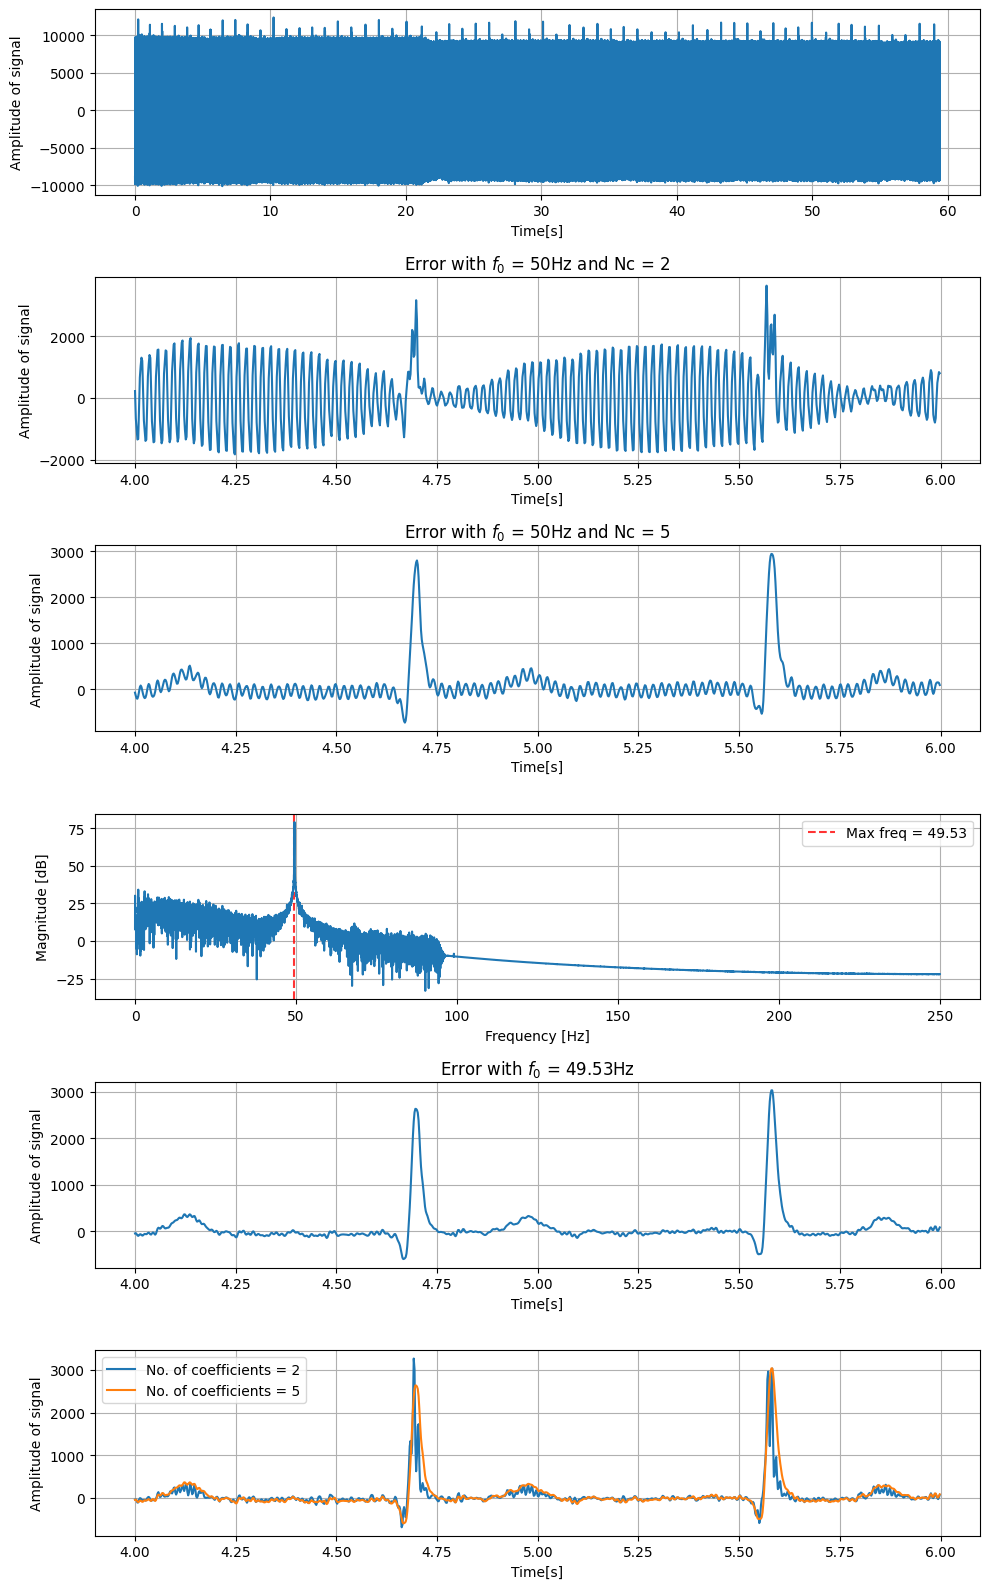

In [240]:
ecg_signal = np.loadtxt("ecg.dat") 
N = len(ecg_signal)
Nc = 5
f0 = 50 #Powerline noise frequency
fs = 500 #Sampling frequency of system
n_samples = len(ecg_signal)
t = np.arange(n_samples) / fs

# FFT ECG-signal
ecg_signal_fft, ecg_signal_fft_db,ecg_signal_freq_max = fft_data(ecg_signal,N,fs)
print("Frequency of maximum energy for ECG signal =",ecg_signal_freq_max)

# Generate reference sinusoidal interference (50 Hz) for 50Hz and fft freq max
reference_signal_normal = np.cos(2 * np.pi * f0 * t)
reference_signal_fft = np.cos(2 * np.pi * ecg_signal_freq_max * t)

# Find stepsize µ for 50Hz and fft freq max
stepsize_normal = step_size(reference_signal_normal, Nc)
stepsize_fft = step_size(reference_signal_fft, Nc)

#Determined optimum weights with LMS
ws_normal_Nc2, ys_normal_Nc2, err_normal_Nc2, _ = LMS(reference_signal_normal, ecg_signal, 2, stepsize_normal)
ws_normal, ys_normal, err_normal, MSE = LMS(reference_signal_normal, ecg_signal, Nc, stepsize_normal)
ws_fft, ys_fft, err_fft, _ = LMS(reference_signal_fft, ecg_signal, Nc, stepsize_fft)
ws_fft_Nc2, ys_fft_Nc2, err_fft_Nc2, _ = LMS(reference_signal_fft, ecg_signal, 2, stepsize_fft)

x1, x2 = 2000,3000

fig, ax = plt.subplots(6,1,figsize=(10,16))
ax[0].plot(t, ecg_signal)
# ax[0].set_title("Original ECG data")
ax[0].set_xlabel("Time[s]")
ax[0].set_ylabel("Amplitude of signal")
ax[0].grid()
ax[1].plot(t[x1:x2], err_normal_Nc2[x1:x2])
ax[1].set_title("Error with $f_0$ = 50Hz and Nc = 2")
ax[1].set_xlabel("Time[s]")
ax[1].set_ylabel("Amplitude of signal")
ax[1].grid()
ax[2].plot(t[x1:x2], err_normal[x1:x2])
ax[2].set_title("Error with $f_0$ = 50Hz and Nc = 5")
ax[2].set_xlabel("Time[s]")
ax[2].set_ylabel("Amplitude of signal")
ax[2].grid()
ax[3].vlines(ecg_signal_freq_max, 0, 1, transform=ax[3].get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8, label=f"Max freq = {ecg_signal_freq_max:.2f}")
ax[3].plot(ecg_signal_fft, ecg_signal_fft_db)
# ax[3].set_title("FFT of ECG signal")
ax[3].set_xlabel("Frequency [Hz]")
ax[3].set_ylabel("Magnitude [dB]")
ax[3].legend()
ax[3].grid()
ax[4].plot(t[x1:x2], err_fft[x1:x2])
ax[4].set_title(f"Error with $f_0$ = {ecg_signal_freq_max:.2f}Hz")
ax[4].set_xlabel("Time[s]")
ax[4].set_ylabel("Amplitude of signal")
ax[4].grid()
ax[5].plot(t[x1:x2],err_fft_Nc2[x1:x2], label="No. of coefficients = 2")
ax[5].plot(t[x1:x2],err_fft[x1:x2], label=f"No. of coefficients = 5")
# ax[5].set_title("Original vs tuned")
ax[5].set_xlabel("Time[s]")
ax[5].set_ylabel("Amplitude of signal")
ax[5].grid()
ax[5].legend()
plt.tight_layout()
plt.show()


1.813614004187975e-09


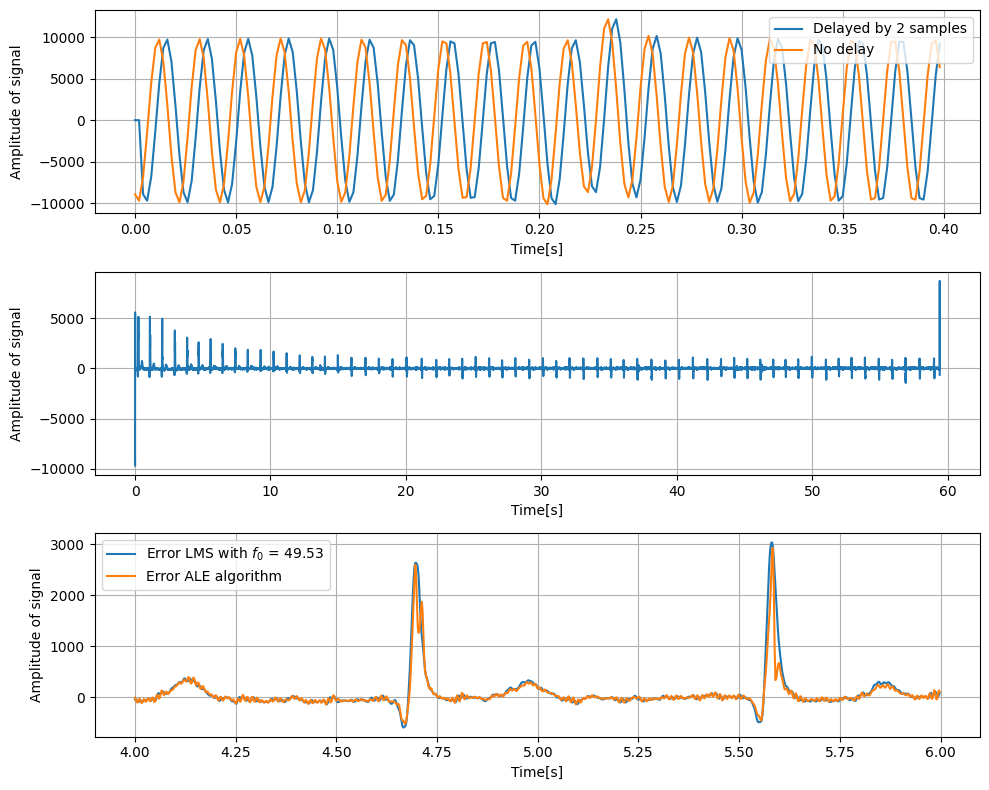

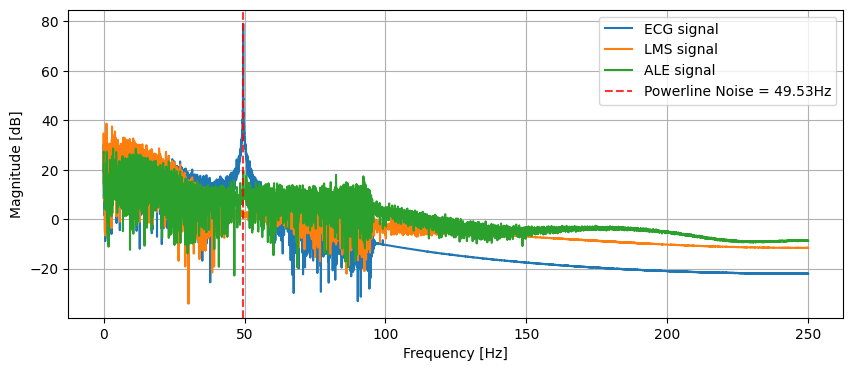

In [243]:
delay = 2
Nc_ALE = 5
ALE_signal, ALE_signal_delayed = ALE(ecg_signal, delay)
t_ale = np.arange(len(ALE_signal)) / fs

# Find stepsize µ for 50Hz and fft freq max
stepsize_ALE = step_size(ALE_signal, Nc_ALE)
print(stepsize_ALE)
#Determined optimum weights with LMS
ws_ALE, ys_ALE, err_ALE, _ = LMS(ALE_signal_delayed, ALE_signal, Nc_ALE, stepsize_ALE)

fig, ax = plt.subplots(3,1,figsize=(10,8))
ax[0].plot(t_ale[0:200], ALE_signal_delayed[0:200],label=f"Delayed by {delay} samples")
ax[0].plot(t_ale[0:200], ALE_signal[0:200],label="No delay")
# ax[0].set_title("ALE signal")
ax[0].set_xlabel("Time[s]")
ax[0].set_ylabel("Amplitude of signal")
ax[0].grid()
ax[0].legend(loc='upper right')
ax[1].plot(t_ale, err_ALE)
# ax[1].set_title("ALE Algorithm Error")
ax[1].set_xlabel("Time[s]")
ax[1].set_ylabel("Amplitude of signal")
ax[1].grid()
x1, x2 = 2000,3000
# ax[2].plot(t[x1:x2],err_normal[x1:x2], label="Error LMS with $f_0$ = 50")
ax[2].plot(t[x1:x2],err_fft[x1:x2], label=f"Error LMS with $f_0$ = {ecg_signal_freq_max:.2f}")
ax[2].plot(t_ale[x1:x2],err_ALE[x1:x2], label=f"Error ALE algorithm")
# ax[2].set_title("LMS vs ALE")
ax[2].set_xlabel("Time[s]")
ax[2].set_ylabel("Amplitude of signal")
ax[2].grid()
ax[2].legend()
plt.tight_layout()
plt.show()

ALE_FFT, ALE_FFT_db, ALE_freq_max = fft_data(err_ALE,N,fs)
LMS_FFT, LMS_FFT_db, LMS_freq_max = fft_data(err_fft,N,fs)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ecg_signal_fft, ecg_signal_fft_db, label='ECG signal')
ax.plot(LMS_FFT,LMS_FFT_db, label='LMS signal')
ax.plot(ALE_FFT, ALE_FFT_db, label='ALE signal')
ax.vlines(ecg_signal_freq_max, 0, 1, transform=ax.get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8, label=f"Powerline Noise = {ecg_signal_freq_max:.2f}Hz")
ax.grid()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude [dB]")
ax.legend()
plt.show()

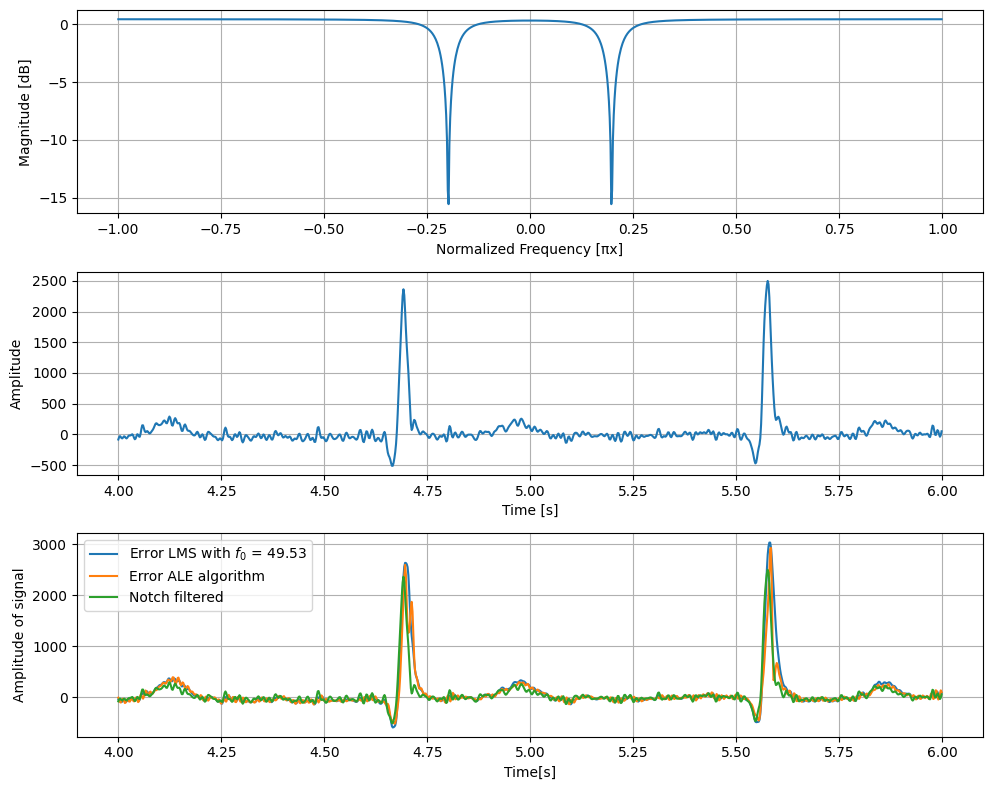

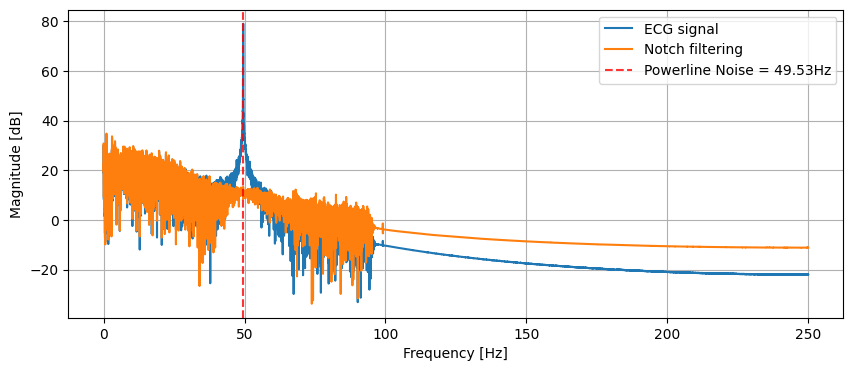

In [248]:
b0 = 1
r = 0.9
x1, x2 = 2000,3000
ECG_notch_filter, num_notch, den_notch = Notch_filter(ecg_signal,b0,r,ecg_signal_freq_max)
fig, ax = plt.subplots(3,1,figsize=(10,8))
f.plotMagResponse(num_notch, den_notch, db=True, ax=ax[0])
ax[0].grid()
# ax[0].set_title("Notch Filter Magnitude Response")
ax[0].set_xlabel("Normalized Frequency [πx]")
ax[0].set_ylabel("Magnitude [dB]")
ax[1].plot(t[x1:x2],ECG_notch_filter[x1:x2])
# ax[1].set_title("Notch Filtered ECG Data")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude")
ax[1].grid()
# ax[2].plot(t[x1:x2], ecg_signal[x1:x2], label="Unfiltered ECG signal")
# ax[2].plot(t[x1:x2], err_normal[x1:x2], label="Error LMS with $f_0$ = 50")
ax[2].plot(t[x1:x2], err_fft[x1:x2], label=f"Error LMS with $f_0$ = {ecg_signal_freq_max:.2f}")
ax[2].plot(t_ale[x1:x2], err_ALE[x1:x2], label=f"Error ALE algorithm")
ax[2].plot(t[x1:x2],ECG_notch_filter[x1:x2], label="Notch filtered")
# ax[2].set_title("LMS vs ALE")
ax[2].set_xlabel("Time[s]")
ax[2].set_ylabel("Amplitude of signal")
ax[2].grid()
ax[2].legend()
plt.tight_layout()
plt.savefig('Notch.png',bbox_inches='tight')
plt.show()

notch_FFT, notch_FFT_db, _ = fft_data(ECG_notch_filter,N,fs)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ecg_signal_fft, ecg_signal_fft_db, label='ECG signal')
# ax.plot(LMS_FFT,LMS_FFT_db, label='LMS signal')
# ax.plot(ALE_FFT, ALE_FFT_db, label='ALE signal')
ax.plot(notch_FFT, notch_FFT_db, label='Notch filtering')
ax.vlines(ecg_signal_freq_max, 0, 1, transform=ax.get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8, label=f"Powerline Noise = {ecg_signal_freq_max:.2f}Hz")
ax.grid()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude [dB]")
ax.legend()
plt.show()



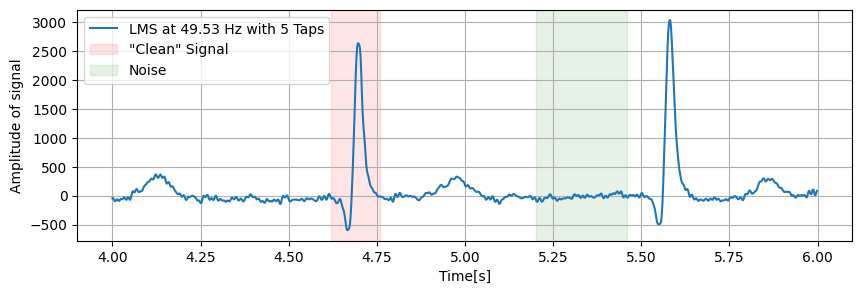

LMS SNR (Nc2) = -3.36 dB
LMS SNR = 19.71 dB
Tuned LMS SNR = 27.57 dB
ALE SNR = 26.25 dB
Notch filtered SNR = 24.90 dB


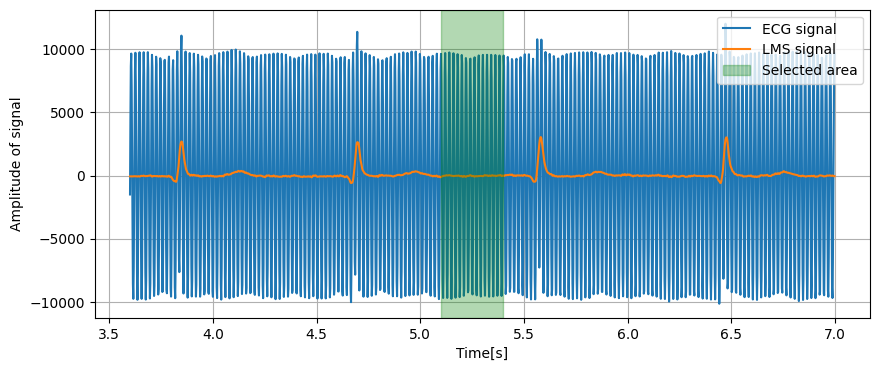

Noise reduction input-output (LMS) = -44.30 dB
Noise reduction input-output (ALE) = -44.90 dB
Noise reduction input-output (Notch) = -44.39 dB


In [252]:
x1,x2 = 2000,3000
samples = [2310,2380,2600,2730]

fig, ax = plt.subplots(figsize=(10,3))
# ax.plot(t[x1:x2], err_normal_Nc2[x1:x2], label='LMS at 50Hz')
# ax.plot(t[x1:x2], err_normal[x1:x2], label='LMS at 50Hz')
ax.plot(t[x1:x2], err_fft[x1:x2], label='LMS at 49.53 Hz with 5 Taps')
# ax.plot(t[x1:x2], err_ALE[x1:x2], label='ALE signal')
# ax.plot(t[x1:x2], ECG_notch_filter[x1:x2], label='Notch signal')
ax.axvspan(samples[0]/fs,samples[1]/fs, alpha=0.1,color='r',label='"Clean" Signal')
ax.axvspan(samples[2]/fs,samples[3]/fs, alpha=0.1,color='g',label='Noise')
ax.set_xlabel("Time[s]")
ax.set_ylabel("Amplitude of signal")
ax.grid()
ax.legend()
plt.show()
snr = calculate_snr(err_fft[samples[0]:samples[1]],err_fft[samples[1]:samples[2]])

LMS_SNR_Nc2 = calculate_snr(err_normal_Nc2[samples[0]:samples[1]], err_normal_Nc2[samples[2]:samples[3]])
LMS_SNR = calculate_snr(err_normal[samples[0]:samples[1]], err_normal[samples[2]:samples[3]])
LMS_tuned_SNR = calculate_snr(err_fft[samples[0]:samples[1]], err_fft[samples[2]:samples[3]])
ALE_SNR = calculate_snr(err_ALE[samples[0]:samples[1]], err_ALE[samples[2]:samples[3]])
Notch_SNR = calculate_snr(ECG_notch_filter[samples[0]:samples[1]], ECG_notch_filter[samples[2]:samples[3]])

print(f"LMS SNR (Nc2) = {LMS_SNR_Nc2:.2f} dB")
print(f"LMS SNR = {LMS_SNR:.2f} dB")
print(f"Tuned LMS SNR = {LMS_tuned_SNR:.2f} dB")
print(f"ALE SNR = {ALE_SNR:.2f} dB")
print(f"Notch filtered SNR = {Notch_SNR:.2f} dB")

# calculate_snr(err_fft[])
x1,x2 = 2550,2700
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t[1800:3500], ecg_signal[1800:3500], label='ECG signal')
ax.plot(t[1800:3500], err_fft[1800:3500], label='LMS signal')
# ax.plot(t[1800:3500], err_ALE[1800:3500], label='LMS signal')
# ax.plot(t[1800:3500], ECG_notch_filter[1800:3500], label='LMS signal')
ax.axvspan(x1/fs,x2/fs, alpha=0.3,color='g',label='Selected area',zorder=2)
ax.set_xlabel("Time[s]")
ax.set_ylabel("Amplitude of signal")
ax.grid()
ax.legend()
plt.show()
print(f"Noise reduction input-output (LMS) = {calculate_snr(err_fft[x1:x2], ecg_signal[x1:x2]):.2f} dB")
print(f"Noise reduction input-output (ALE) = {calculate_snr(err_ALE[x1:x2], ecg_signal[x1:x2]):.2f} dB")
print(f"Noise reduction input-output (Notch) = {calculate_snr(ECG_notch_filter[x1:x2], ecg_signal[x1:x2]):.2f} dB")

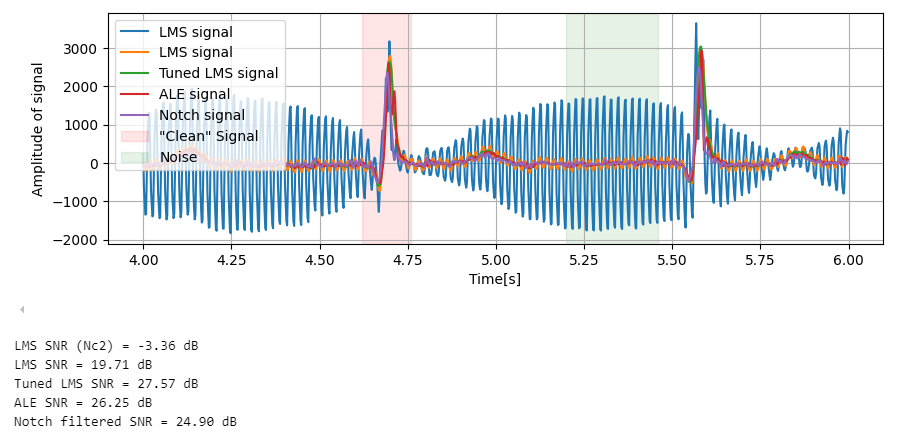

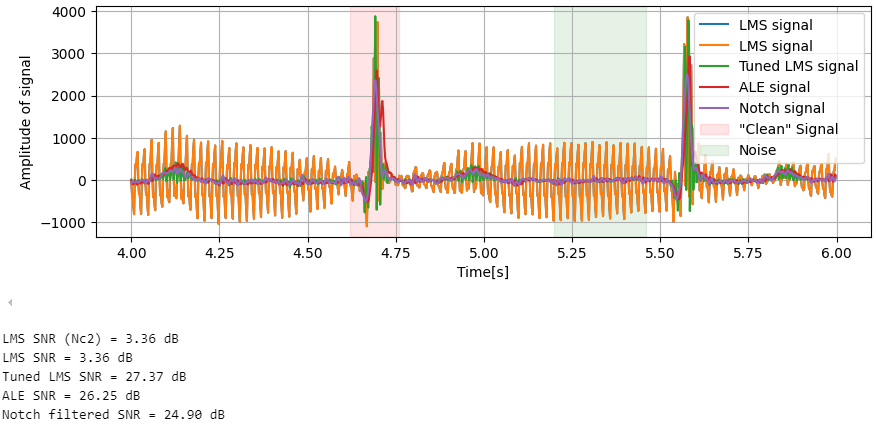

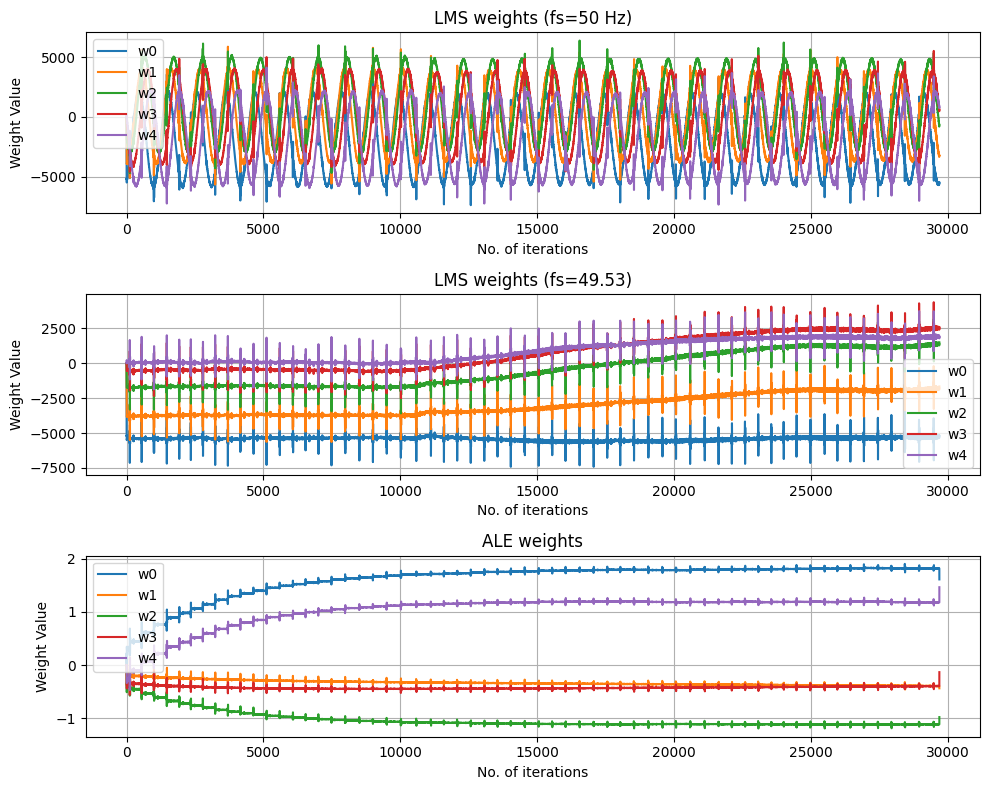

In [237]:
Nc = 5
fig, ax = plt.subplots(3,1,figsize=(10,8))
for w in range(Nc):
    ax[0].plot(ws_normal[:,w], label=f"w{w}")
ax[0].set_xlabel("No. of iterations")
ax[0].set_ylabel("Weight Value")
ax[0].set_title("LMS weights (fs=50 Hz)")
ax[0].legend()
ax[0].grid()
for w in range(Nc):
    ax[1].plot(ws_fft[:,w], label=f"w{w}")
ax[1].set_xlabel("No. of iterations")
ax[1].set_ylabel("Weight Value")
ax[1].set_title("LMS weights (fs=49.53)")
ax[1].legend()
ax[1].grid()
for w in range(Nc):
    ax[2].plot(ws_ALE[:,w], label=f"w{w}")
ax[2].set_xlabel("No. of iterations")
ax[2].set_ylabel("Weight Value")
ax[2].set_title("ALE weights")
ax[2].legend()
ax[2].grid()
plt.tight_layout()
plt.show()